<a href="https://colab.research.google.com/github/TomerRippin/Machine-Learning/blob/master/multi-class-PLA-for-fashion-mnist-dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Maman11 - introduction to machine learning ###
Student: Tomer Rippin
I.D: 322230608

In [ ]:
# Import all of the libraris
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

from tensorflow.keras.datasets import fashion_mnist
from tqdm.notebook import tqdm, trange

### Loading the data ###
Our data consists of 28x28 pixel grayscale images of various clothing items, each
belonging to one of ten categories: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt,
Sneaker, Bag, and Ankle boot.

In [ ]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Dataset Details ###


*   Each image is 28 pixels in height and 28 pixels in width, resulting in a total of 784
pixels per image
*   Each image is 28 pixels in height and 28 pixels in width, resulting in a total of 784
pixels per image

*   Each image represents one of ten clothing categories, with natural variations in
shape, texture, and visual appearance between items
*   Each sample is assigned a label (0 to 9), corresponding to one of ten clothing
categories.





In [ ]:
# A dictionary for the translation of the numeral catagories
# to their matching names.
label2catagory = {
    0: "T-shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

### Data Preprocessing ###
#### **Reshaping**: ####
  We want to reshape the images from 28x28 pixel to a 784x1 vector.
#### **Normalization**: ####
  In this experiment we use the min-max noramalization method.
  The formula for this normalization is:

```
(value-min)÷(max-min)
```
because our min is 0 we can just divide the vectors by 255 to normalize equaly between 0 and 1.


#### **Bias**: ####
  We add a 1 to the start of the vector for the bias so now the shape of every vector is 785x1.

In [ ]:
def preprocess_images(data):
  encoded_data = []
  for image in tqdm(data):
    image = image.reshape(784,)
    image = image / 255  # Normalization
    image = np.insert(image, 0, 1)  # Add the Bias as the first element
    encoded_data.append(image)
  return encoded_data

print("Preprocess train images")
X_train = np.array(preprocess_images(X_train))

print("Preprocess test images")
X_test = np.array(preprocess_images(X_test))

Preprocess train images


  0%|          | 0/60000 [00:00<?, ?it/s]

Preprocess test images


  0%|          | 0/10000 [00:00<?, ?it/s]

Lets look at our data.
First I want to understand the distribution of each of the classes in the test and in the train dataset.

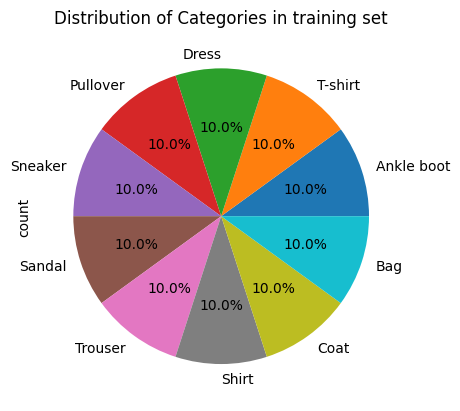

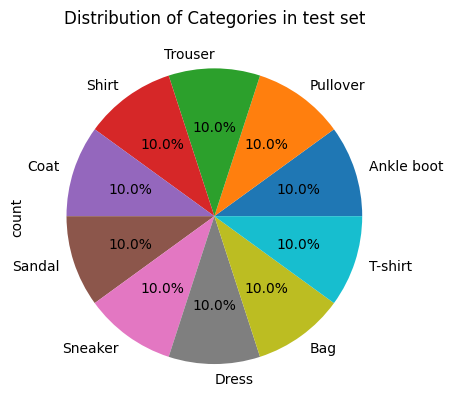

In [ ]:
df = pd.DataFrame(X_train)
df["label"] = pd.Series(y_train).apply(lambda x: label2catagory[x])
counts = df.label.value_counts()
counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Categories in training set')
plt.show()

df = pd.DataFrame(X_test)
df["label"] = pd.Series(y_test).apply(lambda x: label2catagory[x])
counts = df.label.value_counts()
counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Categories in test set')
plt.show()

We can clearly see that the distribution is the same in the test and in the training which will help us get better results.

#### One-Hot encoding ####
we now apply a one-hot encoding for our labels.
instead of 0-9 we will use a 10x1 vector.
we will denote 1 as the "True" label and -1 as the "False" label.
For example:


```
4 ⇒ [-1, -1, -1, 1, -1, -1, -1, -1, -1, -1]
```



In [ ]:
# One-hot encode the labels, from 0-9 labels to a 10-dmensional vector
def one_hot_encode(data):
  encoded_data = []
  for row in tqdm(data):
    one_hot_vector = np.array([-1] * 10)  # initialize a 10x1 vector with -1
    one_hot_vector[row] = 1  # switch the correct label with 1
    encoded_data.append(one_hot_vector)
  return encoded_data

print("Encoding test vectors")
y_test = np.array(one_hot_encode(y_test))


print("Encoding train vectors")
y_train = np.array(one_hot_encode(y_train))

Encoding test vectors


  0%|          | 0/10000 [00:00<?, ?it/s]

Encoding train vectors


  0%|          | 0/60000 [00:00<?, ?it/s]

### multy-class Preceptron classification algorithm (MC-PLA) ###
The Perceptron Learning Algorithm (PLA) for binary classification has been introduced in
class. To extend its application to multi-class classification, we employ the one-vs-all strategy.
This strategy involves training multiple binary PLA classifiers, each dedicated to distinguishing
one class from the rest. In this approach, the multi-class problem is reduced to K binary
problems, where K is the number of classes. (in our case K=10).

**Iterative Binary Problems:**
Subsequently, for each binary problem i from 1 to 9, we assign the label +1 to examples labeled
'i' and -1 to examples labeled '0', '1', '2', ..., '9' (excluding 'i').
The weight vectors resulting from these binary classifications are denoted as:


```
w = [w0, w1 ... w9]
```



**Prediction:**
For a new instance x, the prediction of the label is determined by selecting the class with the
highest confidence score:


```
ŷ = argmax(wʸx) | y∈[0,..9]
```

**The Pocket Algorithm**:
In cases where the data is not linearly separable, the Perceptron Learning Algorithm (PLA) will
never terminate and can exhibit unstable behavior, potentially transitioning from a wellperforming perceptron to a poorly-performing one within a single update. To address this
challenge and obtain an approximate solution, a modification known as the pocket algorithm is
introduced:

1.   ŵ ← w(0)
2.   for t=0...T do: <br>
    &nbsp; Run PLA for one update to optain w(t+1) <br>
    &nbsp; if Ein(w(t+1)) > Ein(ŵ): <br>
    &nbsp; &nbsp; ŵ ← w(t+1)
3. return ŵ


#### Initailization ####
Initialize the w vector with 10 785x1 zero-vectors.

the shape of w now is 10x785

In [ ]:
w = np.array([np.array([0] * 785)] * 10)

#### The Ein function ####
To calculate Ein - the performence metric for the w(t) vector we count the number of correctly classified points (cc) and uncorrectly classified(uc).
<br>
**Note about run-time:**
In my first attempts to run this code i noticed that this function slowed my algorithm running time signifinacly. <br>
I noticed that im using to many "for" loops for the vector multiplication stage and for the evaluation of ŷ. so in this final code i do all of the calculation using numpy faster matrix calculations.

In [ ]:
def Ein(X, Y, w):
    # Predict all samples at once:
    # X.shape (60000, 785)
    # w.T.shape (785, 10)
    # X @ w.T → shape (60000, 10)
    preds = np.argmax(X @ w.T, axis=1)

    # True classes:
    true = np.argmax(Y, axis=1)

    correct_mask = preds == true

    # Slice once (fast)
    cc = (X[correct_mask], Y[correct_mask])
    uc = (X[~correct_mask], Y[~correct_mask])

    return cc, uc


#### The Update Function ####
In the update function we recieve w(t) and we build w(t+1). <br>
the updating process for one vector wi: <br>

```
w(t+1) ← w(t) + (y(t) * x(t))
```
but in this function to conserve running time we do it for all of the vectors w0...w9 at once.


In [ ]:
def update(x, y, w):
    # Compute predictions for all classes at once
    # w.shape(10, 785)
    # x.shape (785, 1)
    pred = np.sign(w @ x)      # shape: (10,)

    # Find which classifiers are wrong
    wrong = pred != y          # boolean mask shape: (10,)

    # Create update matrix by multiplying y*x only for wrong rows
    return w + (wrong * y)[:, None] * x

#### The Pocket Algorithm ####
In this piece code we run the previusly described Pocket algorithm but we store some data along the way for further analsys and graphs.

**Random misclassified point:**
I ran the training algorithem few times and noticed that when i picked for the update function just the first misclassified point the learning rate was much slower and the Ein performance rate had a strong fluctuation. <br>

For that reason, i tested updating with a random misclassified point and the results werw much better.


In [ ]:
train_results = [] # save the results of the classifiers over time
classifiers = [] # save the classifiers for later analsys
iter_number = 1000

# Initialze w_hat to w(0)
w_hat = w

# The most misclassified points you can have
best_performance = 60000

for i in trange(iter_number):
  classifiers.append(w)

  cc, uc = Ein(X_train, y_train, w)

  # unpack the misclassified points
  X_uc, Y_uc = uc

  # number of misclasified points
  performance = len(X_uc)

  if performance < best_performance: # found new w_hat
    w_hat = w
    best_performance = performance

  # Pick random misclassified example and update w
  idx = np.random.randint(len(X_uc))
  x = X_uc[idx]
  y = Y_uc[idx]
  w = update(x, y, w)

  train_results.append((i, 60000-performance))

  0%|          | 0/1000 [00:00<?, ?it/s]

# Results Visualiztion and Analsys #



### The chosen classifier - ŵ analsys ###
Now, after we trained our classifier and found our best classifier ŵ we should start by analyzing it performence on the test data.

In [ ]:
cc, uc = Ein(X_test, y_test, w_hat)
X_cc, y_cc = cc

accuarcy = len(X_cc) / 10000
print(f"Model Accuarcy: {accuarcy}")

Model Accuarcy: 0.7605


### (Fig1) Visualize the learning curve ###
I wanted to visualize the learning curve of the pocket algorithm to show the improvment of the classifiers over time. below is a graph visualizing it.

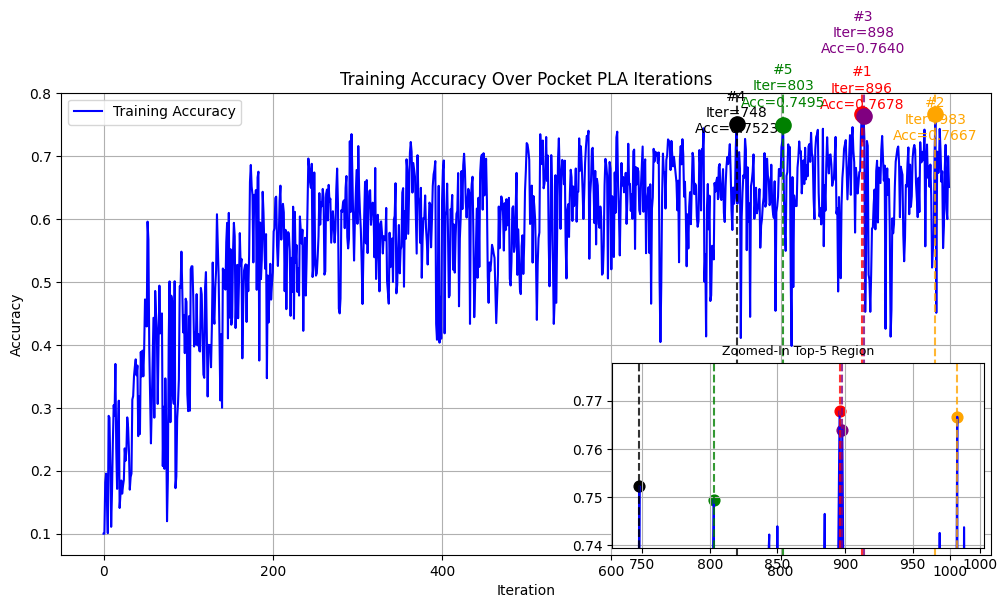

In [ ]:
iters = np.array([r[0] for r in train_results])
train_acc = np.array([r[1] for r in train_results]) / 60000.0

# --- Find Top 5 Iterations ---
top5_idx = np.argsort(train_acc)[-5:][::-1]    # best → 5th best
top5_iters = iters[top5_idx]
top5_accs  = train_acc[top5_idx]

colors = ["red", "orange", "purple", "black", "green"]
offsets = [0.008, -0.04 , 0.1, -0.015, 0.03]    # vertical nudges to avoid overlap

plt.figure(figsize=(12,6))

# Plot the accuracy curve
plt.plot(iters, train_acc, color="blue", label="Training Accuracy")

# Mark and annotate top-3
for rank, (idx, it, acc) in enumerate(zip(top5_idx, top5_iters, top5_accs)):
    color = colors[rank]
    offset = offsets[rank]

    # vertical dotted line
    plt.axvline(it, color=color, linestyle="--", alpha=0.8)

    # scatter point
    plt.scatter(it, acc, color=color, s=120, zorder=5)

    # staggered annotation
    plt.text(it, acc + offset,
             f"#{rank+1}\nIter={it}\nAcc={acc:.4f}",
             color=color, fontsize=10,
             ha="center")

plt.title("Training Accuracy Over Pocket PLA Iterations")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()


from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# inset location: bottom right inside the main plot
ax_inset = inset_axes(plt.gca(), width="40%", height="40%", loc="lower right")

# zoom: select small window around min..max top-3 iterations
zoom_margin = 20
xmin = max(top5_iters.min() - zoom_margin, 0)
xmax = top5_iters.max() + zoom_margin

# plot inside inset
ax_inset.plot(iters, train_acc, color="blue")
ax_inset.set_xlim(xmin, xmax)
ax_inset.set_ylim(train_acc[top5_idx].min() - 0.01,
                  train_acc[top5_idx].max() + 0.01)

# Mark top-3 inside inset
for rank, (it, acc) in enumerate(zip(top5_iters, top5_accs)):
    color = colors[rank]
    ax_inset.axvline(it, color=color, linestyle="--", alpha=0.8)
    ax_inset.scatter(it, acc, color=color, s=60)

ax_inset.set_title("Zoomed-In Top-5 Region", fontsize=9)
ax_inset.grid(True)

plt.show()

### Understanding the Graph ###
As we can see, we had really poor results in the first 150-200 iterations but as the we reached appx ~750 iterations we almost didn't improve as the best result in iteration 896 isnt much better **on the training data** then iteration 748. <br>
For us to conclude if we reached a training platue we should compare the performance and learning rate of the classifiers on the test data also. Lets show it in the next graph.

### (Fig2) Comparing train and test accuarcies ###
First, compute the accuracy of each classifier on the test set.

In [ ]:
def accuracy(X, Y, w):
    y_pred = np.argmax(X @ w.T, axis=1)
    y_true = np.argmax(Y, axis=1)
    return np.mean(y_pred == y_true)

print("Calculating accuarcy on test data")
test_acc = np.array([accuracy(X_test, y_test, w_i) for w_i in tqdm(classifiers)])

Calculating accuarcy on test data


  0%|          | 0/1000 [00:00<?, ?it/s]

Now, we will plot the test and train accuarcies on the same graph and compare them.
Furthermore we will try and see if the best 3 classifiers from the training data are similar to the top 3 in the test data.

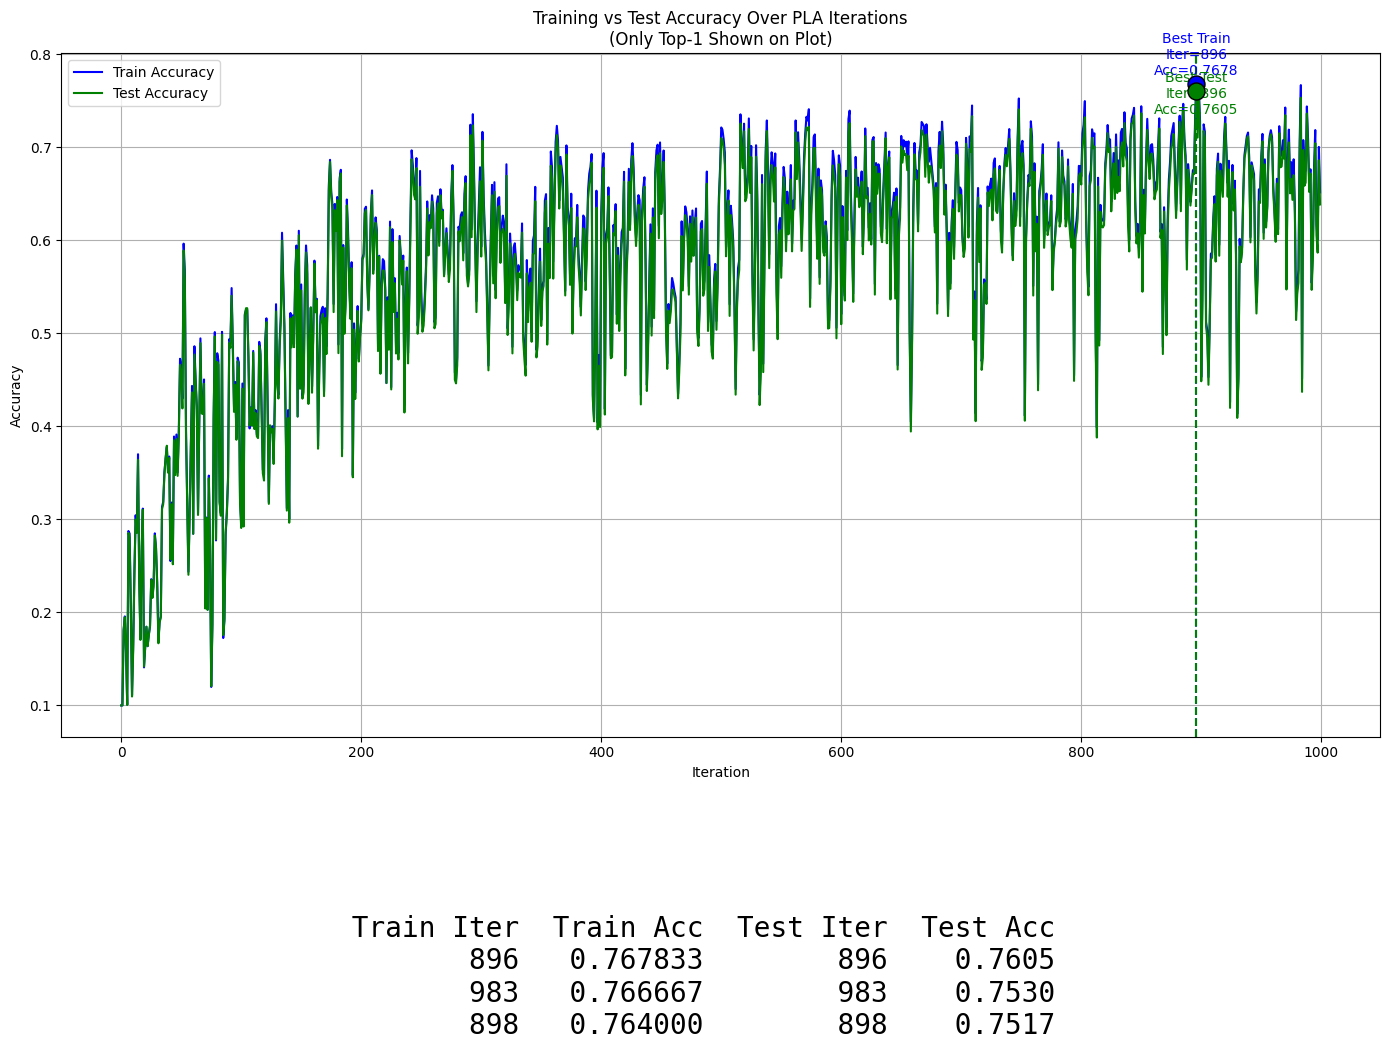

In [ ]:
# Top-3 test
train_top3_idx = np.argsort(train_acc)[-3:][::-1]
train_top3_iters = iters[train_top3_idx]
train_top3_acc   = train_acc[train_top3_idx]

# Top-3 test
test_top3_idx = np.argsort(test_acc)[-3:][::-1]
test_top3_iters = iters[test_top3_idx]
test_top3_acc   = test_acc[test_top3_idx]


plt.figure(figsize=(14,8))

# ---- Plot the accuracy curves ----
plt.plot(iters, train_acc, label="Train Accuracy", color="blue")
plt.plot(iters, test_acc,  label="Test Accuracy",  color="green")

# ---- Mark ONLY the top-1 TRAIN ----
best_train_iter = train_top3_iters[0]
best_train_acc  = train_top3_acc[0]

plt.axvline(best_train_iter, color="blue", linestyle="--", linewidth=1.5)
plt.scatter(best_train_iter, best_train_acc,
            color="blue", s=150, edgecolors="black", zorder=4)

plt.text(best_train_iter, best_train_acc + 0.01,
         f"Best Train\nIter={best_train_iter}\nAcc={best_train_acc:.4f}",
         color="blue", ha="center")

# ---- Mark ONLY the top-1 TEST ----
best_test_iter = test_top3_iters[0]
best_test_acc  = test_top3_acc[0]

plt.axvline(best_test_iter, color="green", linestyle="--", linewidth=1.5)
plt.scatter(best_test_iter, best_test_acc,
            color="green", s=150, edgecolors="black", zorder=4)

plt.text(best_test_iter, best_test_acc - 0.025,
         f"Best Test\nIter={best_test_iter}\nAcc={best_test_acc:.4f}",
         color="green", ha="center")

# ---- Styling ----
plt.title("Training vs Test Accuracy Over PLA Iterations\n(Only Top-1 Shown on Plot)")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

comparison_df = pd.DataFrame({
    "Train Iter": train_top3_iters,
    "Train Acc":  train_top3_acc,
    "Test Iter":  test_top3_iters,
    "Test Acc":   test_top3_acc
})

plt.figtext(0.5, -0.15,
            comparison_df.to_string(index=False),
            ha="center", va="top", fontsize=20, family="monospace")

plt.tight_layout()
plt.show()

In [ ]:
test_top3_idx == train_top3_idx

array([ True,  True,  True])

### Train-Test Comparison Discussion ###
As we just saw, the accuarcy of the training and test data are really close to one another. <br>
 Even the top 3 classifiers on the training data were the top 3 classifiers on the test data!
<br>
We can understand from that result that the **distribution for the train and test set is similar** and that we can use ŵ for classification on other data from the same distribution if needed.

### Number of iterations decision ###
As we just saw, the best classifiers from the train dataset were the best on the test dataset. <br>
As we saw in fig1, the training accuarcies almost didnt improve from the ~750 iteration. as the training running time was 4 and a half minuts and i had a time limit for the running the notebook i decided that the number of 1000 iterations was enough and i didnt want to add more iterations.

### More Ŵ analsys ###
In this part of the notebook we will try and understand why the model was somtimes wrong.

In [ ]:
def predict(X, w):
  """
  X: shape (N, d)
  w: shape (10, d)
  """
  scores = X @ w.T
  return np.argmax(scores, axis=1)

y_true = np.argmax(y_test, axis=1)
y_pred = predict(X_test, w_hat)


### (Fig3) Class-wise Sensetivity ###
we calculate TPR (True-positive rate) or Sensetivity as:


```
TP ÷ (TP + FN)
```
This graph will show us the TPR for each class and will help us asses the classifier power.


In [ ]:
def class_wise_sensitivity(y_true, y_pred, num_classes=10):
    sensitivities = np.zeros(num_classes)

    for c in trange(num_classes):
        # True positives: predicted c AND true c
        TP = np.sum((y_true == c) & (y_pred == c))

        # False negatives: true c but predicted != c
        FN = np.sum((y_true == c) & (y_pred != c))

        # Sensitivity = TP / (TP + FN)
        if TP + FN > 0:
            sensitivities[c] = TP / (TP + FN)
        else:
            sensitivities[c] = 0.0  # or np.nan if you want

    return sensitivities

print ("Calculating sensitivity per class")
sens = class_wise_sensitivity(y_true, y_pred)

Calculating sensitivity per class


  0%|          | 0/10 [00:00<?, ?it/s]

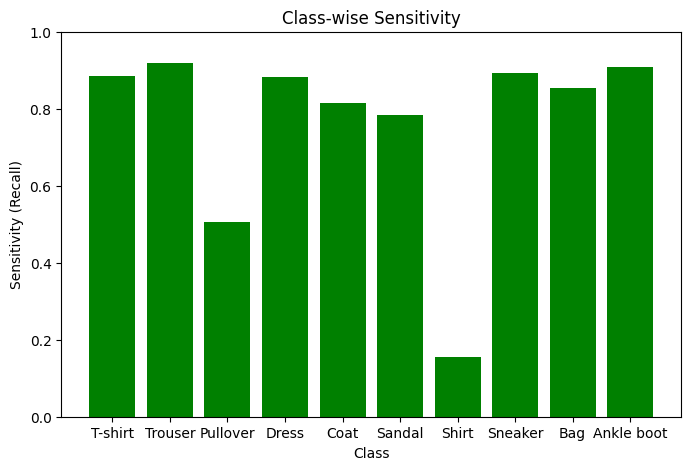

In [ ]:
plt.figure(figsize=(8,5))
# plt.bar(range(len(sens)), sens, color='green')
plt.bar(label2catagory.values(), sens, color='green')
plt.xlabel("Class")
plt.ylabel("Sensitivity (Recall)")
plt.title("Class-wise Sensitivity")
plt.ylim(0, 1)
plt.show()

We can see that Shirt and Pullover have really low TPR while others like Sneaker and Trouser have much better.
we can further analyze this phenomena with the Confusion Matrix.

### (Fig4) Confusion Matrix ###
We want to see the diffrence in our predicting power with different classes.

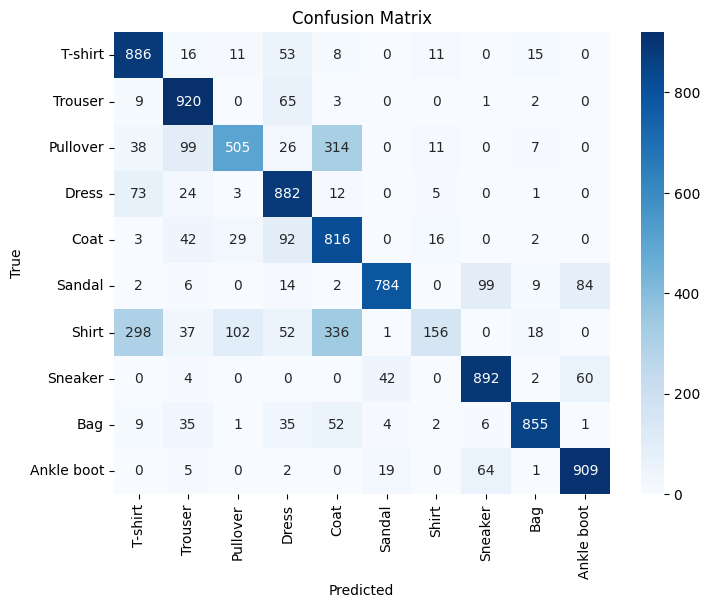

In [ ]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label2catagory.values(),
            yticklabels=label2catagory.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

We can clearly see that the there are some classes that are classified with really high precision like Trousers, Ankle boot and sneakers while our classifier is really bad in classifing pullovers and shirts.

it seems that our classifier mistankly classifies shirt as T-shirt or Coat and Pullovers as Coat.

### Visualy Compare misclassified images ###
In this section of the notebook i want to help us understand the reasoning behind the difference in TPR and Accuarcy between the classes.

Why are some of the classes are predicted correctly and others dont?

### (Fig5) Heatmap comparison ###
In these couple of figures we will try to analyze the classes with the lowest TPR.

We will try to show the reasoning behind the misclassification.

In this example we will see the avg Heatmap for the Shirts, the T-shirts and the Shirts that were misclassified as T-shirts.

Define Class Indices

In [ ]:
SHIRT_INDEX = 6
T_SHIRT_INDEX = 0

# True Shirt (6) -> Predicted Shirt (6) (Correctly Classified) ---
correctly_classified_shirts_indices = np.where((y_true == SHIRT_INDEX) &
 (y_pred == SHIRT_INDEX))[0]
correctly_classified_shirts = X_test[correctly_classified_shirts_indices]

# True Shirt (6) -> Predicted T-shirt (0) (Misclassified) ---
misclassified_shirts_as_tshirts_indices = np.where((y_true == SHIRT_INDEX) &
                                                   (y_pred == T_SHIRT_INDEX))[0]
misclassified_shirts_as_tshirts = X_test[misclassified_shirts_as_tshirts_indices]

# True T-shirt (0) -> Predicted T-shirt (0) (Correctly Classified) ---
correctly_classified_tshirts_indices = np.where((y_true == T_SHIRT_INDEX) &
 (y_pred == T_SHIRT_INDEX))[0]
correctly_classified_tshirts = X_test[correctly_classified_tshirts_indices]

Function to Calculate and Reshape the Average Image

It also removes the bias term from the start


In [ ]:
def calculate_average_image(data):
    """Calculates the average image, removing the bias term (index 0)."""

    # Remove the bias term (index 0) from the 785-dimensional vector
    images_without_bias = data[:, 1:]

    # Calculate the mean across all samples
    average_image_flat = np.mean(images_without_bias, axis=0)

    # Reshape the 784 pixels to 28x28
    return average_image_flat.reshape(28, 28)

# Calculate the Average Images
avg_shirt = calculate_average_image(correctly_classified_shirts)
avg_shirt_as_tshirt = calculate_average_image(misclassified_shirts_as_tshirts)
avg_tshirt = calculate_average_image(correctly_classified_tshirts)

Plotting the three heatmaps

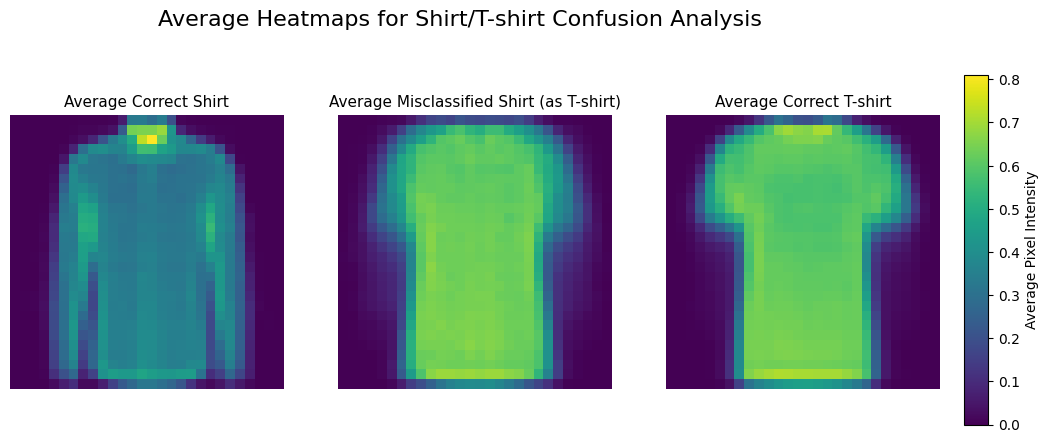

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Average Heatmaps for Shirt/T-shirt Confusion Analysis", fontsize=16)

plots = [
    (avg_shirt, "Average Correct Shirt"),
    (avg_shirt_as_tshirt, "Average Misclassified Shirt (as T-shirt)"),
    (avg_tshirt, "Average Correct T-shirt")
]

# Set a common color scale (vmax) for accurate comparison
vmax = max(img.max() for img, _ in plots)

# Iterate over the 'plots' list, which contains the image data and titles.
# Use the index 'i' to reference the correct subplot axes[i].
for i, (image, title) in enumerate(plots):
    # Access the individual subplot using the index 'i'
    im = axes[i].imshow(image, cmap='viridis', vmin=0, vmax=vmax)
    axes[i].set_title(title, fontsize=11)
    axes[i].axis('off')

# Add a single colorbar for context
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Average Pixel Intensity')

plt.show()

We Can clearly see that the **misclassified Shirts were much more similar to T-shirts then to Shirts!**


# Discussion  and Summury #

In this notebook we trained a multi-class Perceptron classifier on 60,000 28x28 images and tested it on 10,000 diferent images.

We used the Pocket algorithm to find the best classifier after 896 iterations out of 1000. (We also saw that the learning rate almost have no improvment in the last ~300 iterations so we stopped the training)

This classifier denoted as ŵ achived 0.767 accuarcy score which is pretty good for such simple algorithm and short training.

There were some classes that ŵ really struggled to classify correctly (Shirt, Pullover).
We could see a really low sensativity score for those classes (0.18, 0.51) which means really high FN rate.
But, we saw that the misclassified images were similar to the incorrect classification more then to the correct one even in my prespective.
i dont know if i could have been able to classifiy these images correctly!

Visual Similarity between classes can really throw-off the classifier and make the problem much harder. I can imagine that if the problem were to classify only shoes, shirts and bags our algorithm would have much more success.

Another really important lesson learned from this experiment is how crucial is to understand how to accelerate your code using fast implemented vector-multipication in numpy.
when i started to work on this project every learning iteration took my about 3-4 seconds but after i removed "for loops" and inserted vector and matrix multipication i achived *3-4 iteration a second!*